In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import date


%matplotlib inline

In [123]:
df_energy = pd.read_csv('energy_dataset.csv', 
    parse_dates=['time']
)

In [124]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [125]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [126]:
df_energy_new = df_energy.filter(['time','price actual'], axis=1)

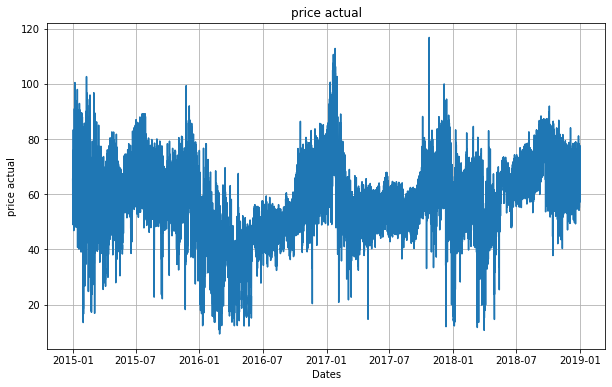

In [127]:
# Plotting the Prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('price actual')
plt.plot(df_energy_new['price actual'])
plt.title('price actual')
plt.show()

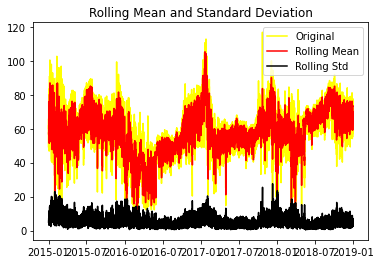

Results of dickey fuller test
Test Statistics               -9.147016e+00
p-value                        2.750493e-15
No. of lags used               5.000000e+01
Number of observations used    3.501300e+04
critical value (1%)           -3.430537e+00
critical value (5%)           -2.861623e+00
critical value (10%)          -2.566814e+00
dtype: float64


In [128]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity((df_energy_new['price actual']))

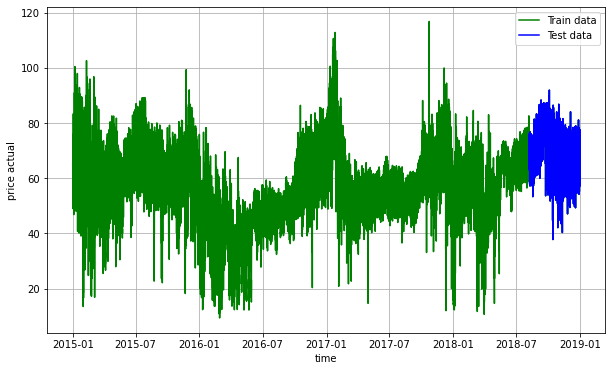

In [129]:
train_data, test_data = df_energy_new[3:int(len(df_energy_new)*0.9)], df_energy_new[int(len(df_energy_new)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price actual')
plt.plot(df_energy_new, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [130]:
train_data = pd.DataFrame(train_data)
train_data.head()

train_data.head()


,price actual
time,
2015-01-01 02:00:00+00:00,59.32
2015-01-01 03:00:00+00:00,56.04
2015-01-01 04:00:00+00:00,53.63
2015-01-01 05:00:00+00:00,51.73
2015-01-01 06:00:00+00:00,51.43


In [131]:
Dytf = [0]
for i in range(1, 31554):
    Dytf.append(train_data.iloc[i]['price actual'] - train_data.iloc[i - 1]['price actual'])
Ytf = [59.32, 56.04]
for i in range(2, 31554):
    Ytf.append(0.2360 + train_data.iloc[i - 1]['price actual'] + 0.2875 * (train_data.iloc[i - 1]['price actual'] - train_data.iloc[i - 2]['price actual']))
Etf = []
for i in range(0, 31554):
    Etf.append(Ytf[i] - train_data.iloc[i]['price actual'])


In [132]:
print(test_data.head())
print(test_data.shape)


                           price actual
time                                   
2018-08-07 20:00:00+00:00         74.12
2018-08-07 21:00:00+00:00         68.43
2018-08-07 22:00:00+00:00         68.97
2018-08-07 23:00:00+00:00         67.31
2018-08-08 00:00:00+00:00         64.71
(3507, 1)


In [133]:
Ytf_h = [74.12, 68.43]
Etf_h = [0, 0]
percentage_error = 0
for i in range(2, 3507):
    Ytf_h.append(0.2360 + test_data.iloc[i - 1]['price actual'] + 0.2875 * (test_data.iloc[i - 1]['price actual'] - test_data.iloc[i - 2]['price actual']))
    Etf_h.append((abs(Ytf_h[i] - test_data.iloc[i]['price actual'])/(test_data.iloc[i]['price actual']))* 100)
    percentage_error += Etf_h[i]
percentage_error /= 3507
test_data = test_data.assign(Ytf = Ytf_h)
test_data = test_data.assign(Etf = Etf_h)
print(test_data.head())
print(percentage_error)

                           price actual        Ytf       Etf
time                                                        
2018-08-07 20:00:00+00:00         74.12  74.120000  0.000000
2018-08-07 21:00:00+00:00         68.43  68.430000  0.000000
2018-08-07 22:00:00+00:00         68.97  67.030125  2.812636
2018-08-07 23:00:00+00:00         67.31  69.361250  3.047467
2018-08-08 00:00:00+00:00         64.71  67.068750  3.645109
2.8992899076533165


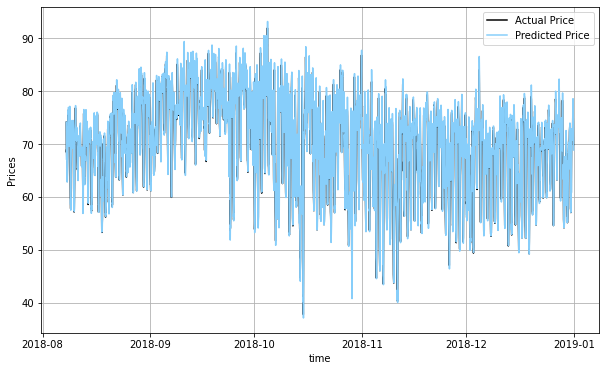

In [122]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('Prices')
plt.plot(test_data['price actual'], 'black', label='Actual Price')
plt.plot(test_data['Ytf'], 'lightskyblue', label='Predicted Price')
plt.legend()

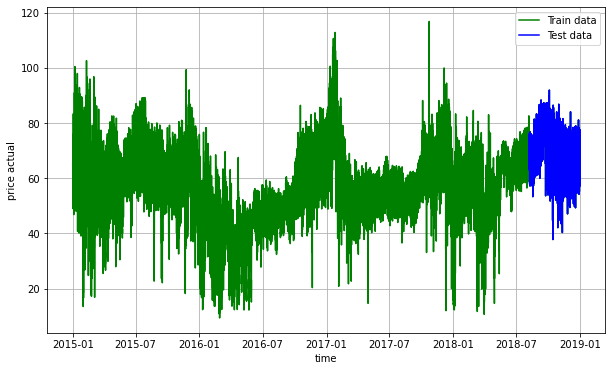

In [54]:
df_energy = pd.read_csv('energy_dataset.csv', 
    parse_dates=['time']
)# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

df_energy_new = df_energy.filter(['time','price actual'], axis=1)
train_data, test_data = df_energy_new[3:int(len(df_energy_new)*0.9)], df_energy_new[int(len(df_energy_new)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price actual')
plt.plot(df_energy_new, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [56]:
Dytf = [0]
for i in range(1, 31554):
    Dytf.append(train_data.iloc[i]['price actual'] - train_data.iloc[i - 1]['price actual'])
Ytf = [59.32, 56.04, 56.63]
for i in range(3, 31554):
    Ytf.append(0.0560 + train_data.iloc[i - 1]['price actual'] + 0.4995 * (train_data.iloc[i - 1]['price actual'] - train_data.iloc[i - 2]['price actual']) - 0.00013 * (train_data.iloc[i - 2]['price actual'] - train_data.iloc[i - 3]['price actual']))
Etf = []
for i in range(0, 31554):
    Etf.append(Ytf[i] - train_data.iloc[i]['price actual'])


In [79]:
Ytf_h = [74.12, 68.43, 68.97]
Etf_h = [0, 0, 0]
percentage_error = 0
for i in range(3, 3507):
    Ytf_h.append(0.0560 + test_data.iloc[i - 1]['price actual'] + 0.4995 * (test_data.iloc[i - 1]['price actual'] - test_data.iloc[i - 2]['price actual']) - 0.00013 * (test_data.iloc[i - 2]['price actual'] - test_data.iloc[i - 3]['price actual']) )
    Etf_h.append((abs(Ytf_h[i] - test_data.iloc[i]['price actual'])/(test_data.iloc[i]['price actual']))* 100)
    percentage_error += Etf_h[i]
percentage_error /= 3507
test_data = test_data.assign(Ytf = Ytf_h)
test_data = test_data.assign(Etf = Etf_h)
print(test_data.head())
print(percentage_error)

                           price actual       Ytf       Etf
time                                                       
2018-08-07 20:00:00+00:00         74.12  74.12000  0.000000
2018-08-07 21:00:00+00:00         68.43  68.43000  0.000000
2018-08-07 22:00:00+00:00         68.97  68.97000  0.000000
2018-08-07 23:00:00+00:00         67.31  69.29647  2.951225
2018-08-08 00:00:00+00:00         64.71  66.53676  2.822995
2.783557140685615


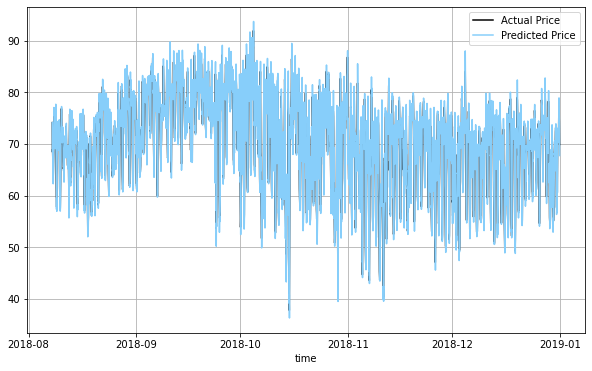

In [87]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.plot(test_data['price actual'], 'black', label='Actual Price')
plt.plot(test_data['Ytf'], 'lightskyblue', label='Predicted Price')
plt.legend(loc='best')

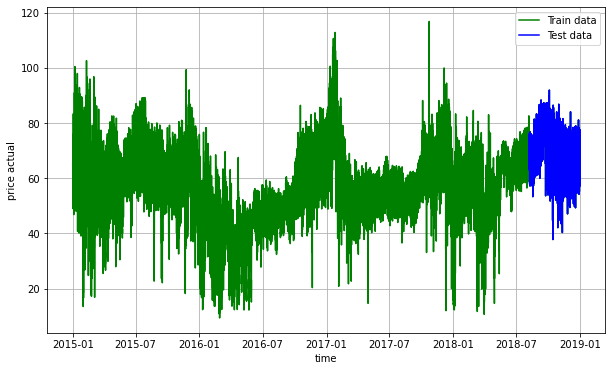

In [88]:
df_energy = pd.read_csv('energy_dataset.csv', 
    parse_dates=['time']
)# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

df_energy_new = df_energy.filter(['time','price actual'], axis=1)
train_data, test_data = df_energy_new[3:int(len(df_energy_new)*0.9)], df_energy_new[int(len(df_energy_new)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price actual')
plt.plot(df_energy_new, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [89]:
Dytf = [0]
for i in range(1, 31554):
    Dytf.append(train_data.iloc[i]['price actual'] - train_data.iloc[i - 1]['price actual'])
Ytf = [59.32, 56.04, 53.63, 51.73]
for i in range(4, 31554):
    Ytf.append(0.0560 + train_data.iloc[i - 1]['price actual'] + 0.4995 * (train_data.iloc[i - 1]['price actual'] - train_data.iloc[i - 2]['price actual']) - 0.00013 * (train_data.iloc[i - 2]['price actual'] - train_data.iloc[i - 3]['price actual']) + 0.0141 * (train_data.iloc[i - 3]['price actual'] - train_data.iloc[i - 4]['price actual']))
Etf = []
for i in range(0, 31554):
    Etf.append(Ytf[i] - train_data.iloc[i]['price actual'])


In [107]:
Ytf_h = [74.12, 68.43, 68.97, 67.31]
Etf_h = [0, 0, 0, 0]
percentage_error = 0
for i in range(4, 3507):
    Ytf_h.append(0.028 + test_data.iloc[i - 1]['price actual'] + 0.4193 * (test_data.iloc[i - 1]['price actual'] - test_data.iloc[i - 2]['price actual']) - 0.00123 * (test_data.iloc[i - 2]['price actual'] - test_data.iloc[i - 3]['price actual']) + 0.0006 * (test_data.iloc[i - 3]['price actual'] - test_data.iloc[i - 4]['price actual']))
    Etf_h.append((abs(Ytf_h[i] - test_data.iloc[i]['price actual'])/(test_data.iloc[i]['price actual']))* 100)
    percentage_error += Etf_h[i]
percentage_error /= 3507
test_data = test_data.assign(Ytf = Ytf_h)
test_data = test_data.assign(Etf = Etf_h)
print(test_data.head())
print(percentage_error)

                           price actual        Ytf       Etf
time                                                        
2018-08-07 20:00:00+00:00         74.12  74.120000  0.000000
2018-08-07 21:00:00+00:00         68.43  68.430000  0.000000
2018-08-07 22:00:00+00:00         68.97  68.970000  0.000000
2018-08-07 23:00:00+00:00         67.31  67.310000  0.000000
2018-08-08 00:00:00+00:00         64.71  66.637884  2.979267
2.779617434789426


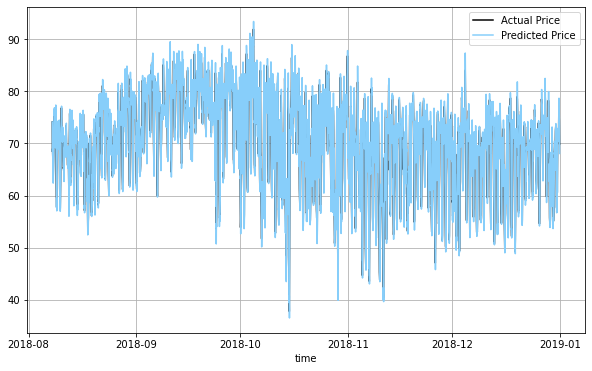

In [108]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.plot(test_data['price actual'], 'black', label='Actual Price')
plt.plot(test_data['Ytf'], 'lightskyblue', label='Predicted Price')
plt.legend(loc='best')